In [1]:
# run_basset
import anndata
import h5py
import scipy
import os
import math
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn import metrics
from scbasset.utils import *


### read the model

In [2]:
ad = anndata.read_h5ad('../../data/downloads/buen_ad_sc.h5ad')
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights('../../data/downloads/buen_model_sc.h5')

2022-10-10 14:38:33.041747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 14:38:33.827038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10410 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


/home/yuanh/programs/anaconda3/envs/tf28/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yuanh/programs/anaconda3/envs/tf28/lib/python3.7/site-packages/scanpy/tools/_tsne.py:115: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  "In previous versions of scanpy, calling tsne with n_jobs > 1 would use "
/home/yuanh/programs/anaconda3/envs/tf28/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


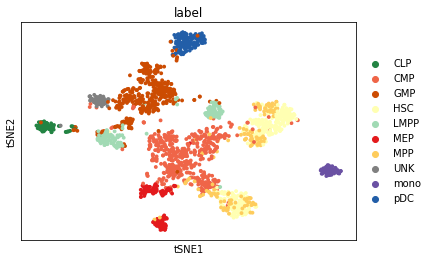

In [3]:
ad.obsm['latent'] = get_cell_embedding(model)

sc.pp.neighbors(ad, use_rep='latent')
sc.tl.tsne(ad, use_rep='latent', n_jobs=8, random_state=700)
sc.pl.tsne(ad, color='label')

### test data

In [4]:
seqs_dna, seqs_coords = make_bed_seqs('../../data/lcr.bed', 
                                      fasta_file='/home/yuanh/programs/genomes/hg19/hg19.fa', 
                                      seq_len=1344)
seq_ref_1hot = dna_1hot(seqs_dna[0])

### run ism

In [5]:
m = ism(seq_ref_1hot, model)
np.save('ism.npy', m)

2022-10-10 14:39:00.980147: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-10-10 14:39:01.472666: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


### visualization

In [6]:
import logomaker

def plot_logo(m, ymin, ymax, ax, title):
    nn_logo = logomaker.Logo(m, ax=ax, baseline_width=0)
    # style using Logo methods
    nn_logo.style_spines(visible=False)
    nn_logo.style_spines(spines=['left'], visible=True, bounds=[ymin, ymax])
    ax.set_ylabel('    saliency', labelpad=-1)
    ax.set_title(title)
    ax.set_ylim(ymin, ymax)
    return(f)

In [7]:
ct = ad.obs['label'].cat.categories
a = np.load('ism.npy')
seq_ref_1hot = dna_1hot(seqs_dna[0])

In [8]:
ref_scores = np.repeat(seq_ref_1hot[np.newaxis,:,:], a.shape[0], axis=0) * (a - np.repeat(a.mean(axis=2)[:,:,np.newaxis], 4, axis=2))
tmp = ref_scores - np.repeat(ref_scores.mean(axis=0)[np.newaxis,:,:], a.shape[0], axis=0)

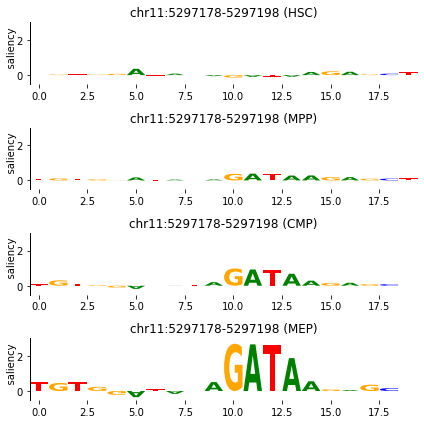

In [9]:
f, axs = plt.subplots(nrows=4, figsize=(6, 6))
cts = ['HSC','MPP','CMP','MEP']
for i in range(4):
    # aggregate cells
    cells = np.where((ad.obs['label']==cts[i]))[0]
    # normalize
    toplot = pd.DataFrame(tmp[cells,:].mean(axis=0), columns = ['A', 'C', 'G', 'T'])
    toplot = toplot.iloc[740:760,:]
    toplot.index = np.arange(toplot.shape[0])
    plot_logo(toplot, -0.5, 3, axs[i], '%s:%d-%d (%s)'%(seqs_coords[0][0],seqs_coords[0][1]+740, seqs_coords[0][1]+760, cts[i]))

f.tight_layout()
#f.savefig('mep_lineage.pdf')

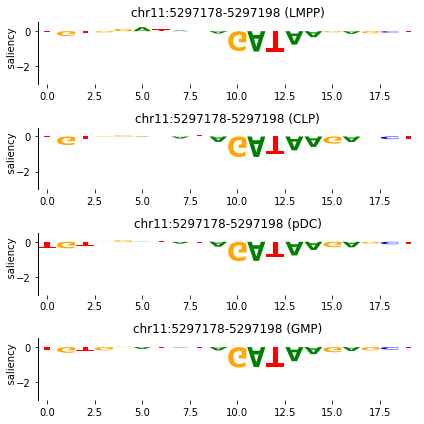

In [10]:
f, axs = plt.subplots(nrows=4, figsize=(6, 6))
cts = ['LMPP','CLP','pDC','GMP']
for i in range(4):
    # aggregate cells
    cells = np.where((ad.obs['label']==cts[i]))[0]
    # normalize
    toplot = pd.DataFrame(tmp[cells,:].mean(axis=0), columns = ['A', 'C', 'G', 'T'])
    toplot = toplot.iloc[740:760,:]
    toplot.index = np.arange(toplot.shape[0])
    plot_logo(toplot, -3, 0.5, axs[i], '%s:%d-%d (%s)'%(seqs_coords[0][0],seqs_coords[0][1]+740, seqs_coords[0][1]+760, cts[i]))

f.tight_layout()
#f.savefig('mep_lineage.pdf')